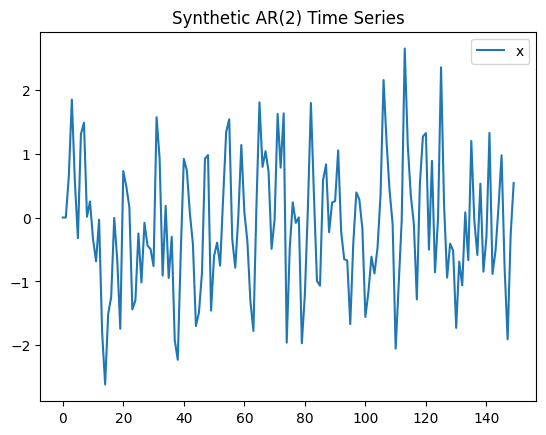

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

np.random.seed(42)

# Generate synthetic AR(2) time series: xt = 0.5*xt-1 - 0.2*xt-2 + e_t
n = 150
x = np.zeros(n)
e = np.random.normal(0, 1, n)

for t in range(2, n):
    x[t] = 0.5 * x[t-1] - 0.2 * x[t-2] + e[t]

df = pd.DataFrame({'x': x})
df.plot(title="Synthetic AR(2) Time Series")
plt.show()


In [25]:
# Lag features
df['x_lag1'] = df['x'].shift(1)
df['x_lag2'] = df['x'].shift(2)

# Drop NA values from lags
df = df.dropna()

# Split train/test
train = df.iloc[:120].copy()
test = df.iloc[120:].copy()

# Fit AR(1)
X_ar1 = train[['x_lag1']]
y = train['x']
coef_ar1 = np.linalg.lstsq(np.c_[np.ones(len(X_ar1)), X_ar1], y, rcond=None)[0]

X_ar2 = train[['x_lag1', 'x_lag2']]

coef_ar2 = np.linalg.lstsq(np.c_[np.ones(len(X_ar2)), X_ar2], y, rcond = None)[0]

print(f"AR1 coefs {coef_ar1}")

AR1 coefs [-0.10547321  0.37222776]


In [28]:
def forecast_ar(model, row, order):
    if order == 1:
        return model[0] + model[1] * row['x_lag1']
    elif order == 2:
        return model[0] + model[1] * row['x_lag1'] + model[2] * row['x_lag2']

# One-step-ahead forecast
test['pred_ar1'] = test.apply(lambda row: forecast_ar(coef_ar1, row, 1), axis=1)
test['pred_ar2'] = test.apply(lambda row: forecast_ar(coef_ar2, row, 2), axis=1)


In [30]:
rmse_ar1 = np.sqrt(mean_squared_error(test['x'], test['pred_ar1']))

rmse_ar2 = np.sqrt(mean_squared_error(test['x'], test['pred_ar2']))


print(f"Out-of-sample RMSE - AR(1): {rmse_ar1:.4f}")
print(f"Out-of-sample RMSE - AR(2): {rmse_ar2:.4f}")


Out-of-sample RMSE - AR(1): 0.9150
Out-of-sample RMSE - AR(2): 0.9275


In [31]:
# Let's simulate 4-period forecasts starting from last test point
x0 = test['x'].iloc[-2]
x1 = test['x'].iloc[-1]

future = []
for i in range(4):
    x_new = coef_ar2[0] + coef_ar2[1]*x1 + coef_ar2[2]*x0
    future.append(x_new)
    x0, x1 = x1, x_new  # shift for next step

print("4-step chain rule forecast (AR2):", future)


4-step chain rule forecast (AR2): [0.1966763573744018, -0.1822530640924887, -0.26864758384660214, -0.20841181483392804]
